# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import Imputer
from sklearn.pipeline import Pipeline

from cleaning import clean_data,print_important_features

# magic word for producing visualizations in notebook
%matplotlib inline

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

In [2]:
# load in the data
azdias = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_AZDIAS_052018.csv', sep=';')
customers = pd.read_csv('../../data/Term2/capstone/arvato_data/Udacity_CUSTOMERS_052018.csv', sep=';')

/opt/conda/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
#display all the columns of dataset
pd.set_option('display.max_columns',None)

In [4]:
#display all the rows of dataset
pd.set_option('display.max_rows',None)

In [5]:
# Shape and head of general data
print("General population shape {}.".format(azdias.shape))
azdias.head()

General population shape (891221, 366).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [6]:
#descriptive statistics of azdias dataset
azdias.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

In [7]:
# Shape and head of customers data
print("Customers shape {}.".format(customers.shape))
customers.head()

Customers shape (191652, 369).


,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LETZTER_KAUF_BRANCHE,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEFUEGT_AM,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,

In [8]:
#descriptive statistics of customers dataset
customers.describe()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,CJT_GESAMTTYP,CJT_KATALOGNUTZER,CJT_TYP_1,CJT_TYP_2,CJT_TYP_3,CJT_TYP_4,CJT_TYP_5,CJT_TYP_6,D19_BANKEN_ANZ_12,D19_BANKEN_ANZ_24,D19_BANKEN_DATUM,D19_BANKEN_DIREKT,D19_BANKEN_GROSS,D19_BANKEN_LOKAL,D19_BANKEN_OFFLINE_DATUM,D19_BANKEN_ONLINE_DATUM,D19_BANKEN_ONLINE_QUOTE_12,D19_BANKEN_REST,D19_BEKLEIDUNG_GEH,D19_BEKLEIDUNG_REST,D19_BILDUNG,D19_BIO_OEKO,D19_BUCH_CD,D19_DIGIT_SERV,D19_DROGERIEARTIKEL,D19_ENERGIE,D19_FREIZEIT,D19_GARTEN,D19_GESAMT_ANZ_12,D19_GESAMT_ANZ_24,D19_GESAMT_DATUM,D19_GESAMT_OFFLINE_DATUM,D19_GESAMT_ONLINE_DATUM,D19_GESAMT_ONLINE_QUOTE_12,D19_HANDWERK,D19_HAUS_DEKO,D19_KINDERARTIKEL,D19_KONSUMTYP,D19_KONSUMTYP_MAX,D19_KOSMETIK,D19_LEBENSMITTEL,D19_LOTTO,D19_NAHRUNGSERGAENZUNG,D19_RATGEBER,D19_REISEN,D19_SAMMELARTIKEL,D19_SCHUHE,D19_SONSTIGE,D19_SOZIALES,D19_TECHNIK,D19_TELKO_ANZ_12,D19_TELKO_ANZ_24,D19_TELKO_DATUM,D19_TELKO_MOBILE,D19_TELKO_OFFLINE_DATUM,D19_TELKO_ONLINE_DATUM,D19_TELKO_ONLINE_QUOTE_12,D19_TELKO_REST,D19_TIERARTIKEL,D19_VERSAND_ANZ_12,D19_VERSAND_ANZ_24,D19_VERSAND_DATUM,D19_VERSAND_OFFLINE_DATUM,D19_VERSAND_ONLINE_DATUM,D19_VERSAND_ONLINE_QUOTE_12,D19_VERSAND_REST,D19_VERSI_ANZ_12,D19_VERSI_ANZ_24,D19_VERSI_DATUM,D19_VERSI_OFFLINE_DATUM,D19_VERSI_ONLINE_DATUM,D19_VERSI_ONLINE_QUOTE_12,D19_VERSICHERUNGEN,D19_VOLLSORTIMENT,D19_WEIN_FEINKOST,DSL_FLAG,EINGEZOGENAM_HH_JAHR,EWDICHTE,EXTSEL992,FINANZ_ANLEGER,FINANZ_HAUSBAUER,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_UNAUFFAELLIGER,FINANZ_VORSORGER,FINANZTYP,FIRMENDICHTE,GEBAEUDETYP,GEBAEUDETYP_RASTER,GEBURTSJAHR,GEMEINDETYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,HH_DELTA_FLAG,HH_EINKOMMEN_SCORE,INNENSTADT,KBA05_ALTER1,KBA05_ALTER2,KBA05_ALTER3,KBA05_ALTER4,KBA05_ANHANG,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_AUTOQUOT,KBA05_BAUMAX,KBA05_CCM1,KBA05_CCM2,KBA05_CCM3,KBA05_CCM4,KBA05_DIESEL,KBA05_FRAU,KBA05_GBZ,KBA05_HERST1,KBA05_HERST2,KBA05_HERST3,KBA05_HERST4,KBA05_HERST5,KBA05_HERSTTEMP,KBA05_KRSAQUOT,KBA05_KRSHERST1,KBA05_KRSHERST2,KBA05_KRSHERST3,KBA05_KRSKLEIN,KBA05_KRSOBER,KBA05_KRSVAN,KBA05_KRSZUL,KBA05_KW1,KBA05_KW2,KBA05_KW3,KBA05_MAXAH,KBA05_MAXBJ,KBA05_MAXHERST,KBA05_MAXSEG,KBA05_MAXVORB,KBA05_MOD1,KBA05_MOD2,KBA05_MOD3,KBA05_MOD4,KBA05_MOD8,KBA05_MODTEMP,KBA05_MOTOR,KBA05_MOTRAD,KBA05_SEG1,KBA05_SEG10,KBA05_SEG2,KBA05_SEG3,KBA05_SEG4,KBA05_SEG5,KBA05_SEG6,KBA05_SEG7,KBA05_SEG8,KBA05_SEG9,KBA05_VORB0,KBA05_VORB1,KBA05_VORB2,KBA05_ZUL1,KBA05_ZUL2,KBA05_ZUL3,KBA05_ZUL4,KBA13_ALTERHALTER_30,KBA13_ALTERHALTER_45,KBA13_ALTERHALTER_60,KBA13_ALTERHALTER_61,KBA13_ANTG1,KBA13_ANTG2,KBA13_ANTG3,KBA13_ANTG4,KBA13_ANZAHL_PKW,KBA13_AUDI,KBA13_AUTOQUOTE,KBA13_BAUMAX,KBA13_BJ_1999,KBA13_BJ_2000,KBA13_BJ_2004,KBA13_BJ_2006,KBA13_BJ_2008,KBA13_BJ_2009,KBA13_BMW,KBA13_CCM_0_1400,KBA13_CCM_1000,KBA13_CCM_1200,KBA13_CCM_1400,KBA13_CCM_1401_2500,KBA13_CCM_1500,KBA13_CCM_1600,KBA13_CCM_1800,KBA13_CCM_2000,KBA13_CCM_2500,KBA13_CCM_2501,KBA13_CCM_3000,KBA13_CCM_3001,KBA13_FAB_ASIEN,KBA13_FAB_SONSTIGE,KBA13_FIAT,KBA13_FORD,KBA13_GBZ,KBA13_HALTER_20,KBA13_HALTER_25,KBA13_HALTER_30,KBA13_HALTER_35,KBA13_HALTER_40,KBA13_HALTER_45,KBA13_HALTER_50,KBA13_HALTER_55,KBA13_HALTER_60,KBA13_HALTER_65,KBA13_HALTER_66,KBA13_HERST_ASIEN,KBA13_HERST_AUDI_VW,KBA13_HERST_BMW_BENZ,KBA13_HERST_EUROPA,KBA13_HERST_FORD_OPEL,KBA13_HERST_SONST,KBA13_HHZ,KBA13_KMH_0_140,KBA13_KMH_110,KBA13_KMH_140,KBA13_KMH_140_210,KBA13_KMH_180,KBA13_KMH_210,KBA13_KMH_211,KBA13_KMH_250,KBA13_KMH_251,KBA13_KRSAQUOT,KBA13_KRSHERST_AUDI_VW,KBA13_KRSHERST_BMW_BENZ,KBA13_KRSHERST_FORD_OPEL,KBA13_KRSSEG_KLEIN,KBA13_KRSSEG_OBER,KBA13_KRSSEG_VAN,KBA13_KRSZUL_NEU,KBA13_KW_0_60,KBA13_KW_110,KBA13_KW_120,KBA13_KW_121,KBA13_KW_30,KBA13_KW_40,KBA13_KW_50,KBA13_KW_60,KBA13_KW_61_120,KBA13_KW_70,KBA13_KW_80,KBA13_KW_90,KBA13_MAZDA,KBA13_MERCEDES,KBA13_MOTOR,KBA13_NISSAN,KBA13_OPEL,KBA13_PEUGE

### Missing values 

In [9]:
#number of missing values by each column in azdias dataset
col_nul_percent=azdias.isnull().sum()/azdias.shape[0]

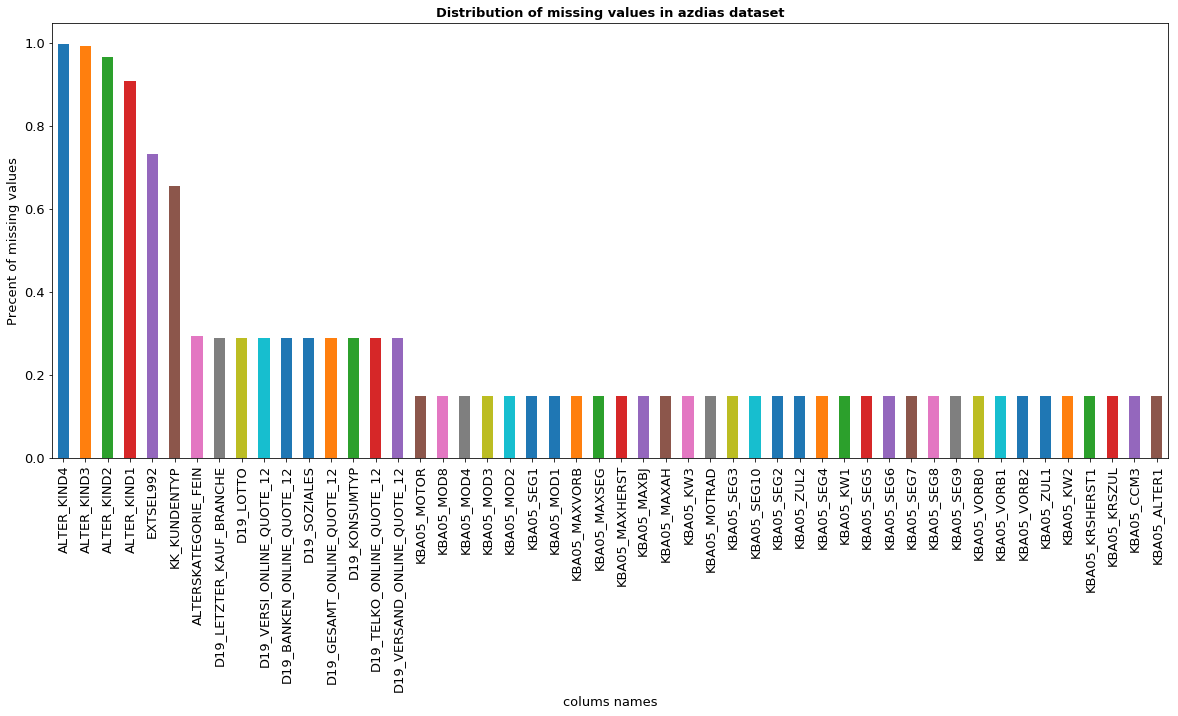

In [10]:
plt.title("Distribution of missing values in azdias dataset",fontsize=13,fontweight="bold")
plt.xlabel("colums names",fontsize=13)
plt.ylabel("Precent of missing values",fontsize=13)
(col_nul_percent.sort_values(ascending=False)[:50].plot(kind='bar', figsize=(20,8), fontsize=13));

In [11]:
#Distribution of missing values by columns:-
missing_by_col=azdias.isnull().sum()/azdias.shape[0]  

Text(0,0.5,'count')

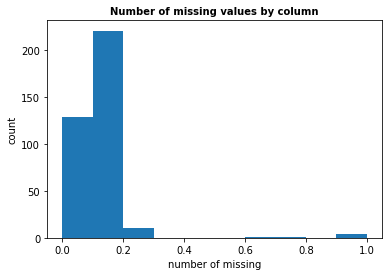

In [12]:
plt.hist(missing_by_col)
plt.title("Number of missing values by column",fontsize=10,fontweight="bold")
plt.xlabel("number of missing",fontsize=10)
plt.ylabel("count",fontsize=10)

In [13]:
#Distribution of missing values by rows:-
row_nul_percent=azdias.isnull().sum(axis=1)  

Text(0,0.5,'count')

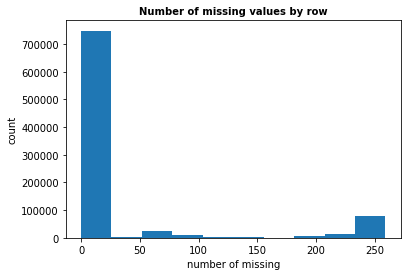

In [14]:
plt.hist(row_nul_percent)
plt.title("Number of missing values by row",fontsize=10,fontweight="bold")
plt.xlabel("number of missing",fontsize=10)
plt.ylabel("count",fontsize=10)

In [15]:
#droping columns that have more than 20% of missing values
column_nans = azdias.isnull().mean()
drop_cols = azdias.columns[column_nans > 0.20]
print('columns to drop: ', drop_cols)

columns to drop:  Index(['ALTER_KIND1', 'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4',
       'ALTERSKATEGORIE_FEIN', 'D19_BANKEN_ONLINE_QUOTE_12',
       'D19_GESAMT_ONLINE_QUOTE_12', 'D19_KONSUMTYP',
       'D19_LETZTER_KAUF_BRANCHE', 'D19_LOTTO', 'D19_SOZIALES',
       'D19_TELKO_ONLINE_QUOTE_12', 'D19_VERSAND_ONLINE_QUOTE_12',
       'D19_VERSI_ONLINE_QUOTE_12', 'EXTSEL992', 'KK_KUNDENTYP'],
      dtype='object')


In [16]:
#droping columns that are start with KBA05
kba_cols = azdias.columns[azdias.columns.str.startswith('KBA05')]
kba_cols

Index(['KBA05_ALTER1', 'KBA05_ALTER2', 'KBA05_ALTER3', 'KBA05_ALTER4',
       'KBA05_ANHANG', 'KBA05_ANTG1', 'KBA05_ANTG2', 'KBA05_ANTG3',
       'KBA05_ANTG4', 'KBA05_AUTOQUOT', 'KBA05_BAUMAX', 'KBA05_CCM1',
       'KBA05_CCM2', 'KBA05_CCM3', 'KBA05_CCM4', 'KBA05_DIESEL', 'KBA05_FRAU',
       'KBA05_GBZ', 'KBA05_HERST1', 'KBA05_HERST2', 'KBA05_HERST3',
       'KBA05_HERST4', 'KBA05_HERST5', 'KBA05_HERSTTEMP', 'KBA05_KRSAQUOT',
       'KBA05_KRSHERST1', 'KBA05_KRSHERST2', 'KBA05_KRSHERST3',
       'KBA05_KRSKLEIN', 'KBA05_KRSOBER', 'KBA05_KRSVAN', 'KBA05_KRSZUL',
       'KBA05_KW1', 'KBA05_KW2', 'KBA05_KW3', 'KBA05_MAXAH', 'KBA05_MAXBJ',
       'KBA05_MAXHERST', 'KBA05_MAXSEG', 'KBA05_MAXVORB', 'KBA05_MOD1',
       'KBA05_MOD2', 'KBA05_MOD3', 'KBA05_MOD4', 'KBA05_MOD8', 'KBA05_MODTEMP',
       'KBA05_MOTOR', 'KBA05_MOTRAD', 'KBA05_SEG1', 'KBA05_SEG10',
       'KBA05_SEG2', 'KBA05_SEG3', 'KBA05_SEG4', 'KBA05_SEG5', 'KBA05_SEG6',
       'KBA05_SEG7', 'KBA05_SEG8', 'KBA05_SEG9', 'KBA05_VO

In [17]:
#selecting categorical columns for feature engineering
azdias.select_dtypes(include=['object']).columns

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')

## Data Preprocessing

#### Start cleaning the azdias dataset

In [3]:
cleaned_azdias=clean_data(azdias)

Drop columns with more than 20% of missing values
Droping unnecessary columns that doesn't have description in Attribute Info file
droping column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE because it contain too many different items
droping ID column from dataset
creating a copy of dataframe
Remove rows with less than 25 missing attributes
Re-encode OST_WEST_KZ attribute
Feature engineering WOHLANG
Droping WOHLANG column
Feature extracting CAMEO_DEUG_2015
remove columns with start with kba05
Imputing Nan values
Counting Nan values 0


In [4]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,TYPE_QUALITY_NEIGHBOURHOOD
0,1.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,6.0,...,0.0,0.0,2.0,3.0,6.0,0.0,9.0,3.0,2.0,2.0
11,1.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,6.0,...,0.0,0.0,2.0,3.0,6.0,0.0,9.0,3.0,2.0,2.0
12,5.0,14.0,1.0,0.0,0.0,2.0,1.0,0.0,3.0,2.0,...,4.0,1.0,4.0,3.0,5.0,6.0,4.0,1.0,3.0,2.0
13,8.0,20.0,2.0,0.0,0.0,1.0,2.0,0.0,3.0,7.0,...,0.0,0.0,2.0,3.0,6.0,6.0,3.0,5.0,1.0,0.0
14,1.0,15.0,1.0,0.0,0.0,1.0,1.0,0.0,3.0,6.0,...,0.0,0.0,2.0,3.0,6.0,0.0,9.0,3.0,3.0,2.0


In [5]:
#shape of dataset after preprocessing and cleaning 
cleaned_azdias.shape

(139890, 247)

In [6]:
# Apply feature scaling to the general population demographics data(azdias).
scaler = StandardScaler()

In [7]:
cleaned_azdias[cleaned_azdias.columns] = scaler.fit_transform(cleaned_azdias)

In [8]:
cleaned_azdias.head()

,AKT_DAT_KL,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,ARBEIT,BALLRAUM,...,VERDICHTUNGSRAUM,VHA,VHN,VK_DHT4A,VK_DISTANZ,W_KEIT_KIND_HH,WOHNDAUER_2008,ZABEOTYP,ALTERSKATEGORIE_GROB,TYPE_QUALITY_NEIGHBOURHOOD
0,-0.526228,0.064174,-0.144469,-0.048686,-0.268848,-0.412681,-0.154808,-0.040487,0.060202,0.368774,...,-0.255187,-0.230648,-0.109723,-0.516461,-0.261964,-0.593756,0.469833,-0.156567,-0.557607,0.431567
11,-0.526228,0.064174,-0.144469,-0.048686,-0.268848,-0.412681,-0.154808,-0.040487,0.060202,0.368774,...,-0.255187,-0.230648,-0.109723,-0.516461,-0.261964,-0.593756,0.469833,-0.156567,-0.557607,0.431567
12,0.852235,-0.289765,-0.144469,-0.048686,-0.268848,0.800540,-0.154808,-0.040487,0.060202,-2.500722,...,0.535666,1.126748,3.482833,-0.516461,-0.710135,2.507889,-2.438967,-2.144776,0.483524,0.431567
13,1.886083,1.833867,-0.028426,-0.048686,-0.268848,-0.412681,-0.023009,-0.040487,0.060202,1.086148,...,-0.255187,-0.230648,-0.109723,-0.516461,-0.261964,2.507889,-3.020727,1.831643,-1.598737,-2.999047
14,-0.526228,0.064174,-0.144469,-0.048686,-0.268848,-0.412681,-0.154808,-0.040487,0.060202,0.368774,...,-0.255187,-0.230648,-0.109723,-0.516461,-0.261964,-0.593756,0.469833,-0.156567,0.483524,0.431567


## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

#### Apply PCA to the data.

In [9]:
%%time
pca = PCA()
azdias_pca = pca.fit_transform(cleaned_azdias)

CPU times: user 37.8 s, sys: 41.5 ms, total: 37.8 s
Wall time: 38.1 s


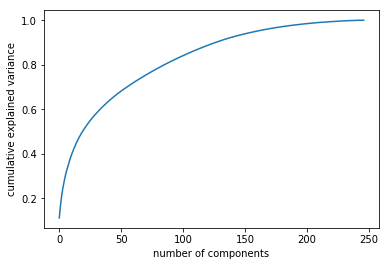

In [10]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.figure(figsize=(10,15))

In [11]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 100.0


In [12]:
%%time
#Apply 170 componets to PCA
pca = PCA(170)
azdias_pca = pca.fit_transform(cleaned_azdias)

CPU times: user 34.2 s, sys: 487 ms, total: 34.7 s
Wall time: 39.6 s


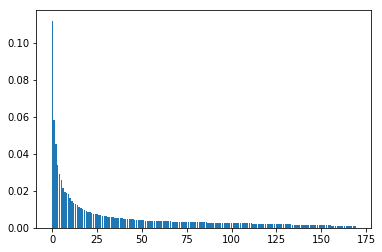

In [13]:
#Investigate the variance accounted for by each principal component.
num_components=len(pca.explained_variance_ratio_)
ind = np.arange(num_components)
vals = pca.explained_variance_ratio_
plt.bar(ind, vals)
plt.show()

In [14]:
explained_var_ratio = sum(pca.explained_variance_ratio_)
print("Explained variance ratio:", explained_var_ratio.round(2)*100)

Explained variance ratio: 96.0


### PCA Interpretation

In [15]:
# First principal component
i = 1
print('{:5.2%}'.format(vals[i]))
print("PCA 1")
#calling a function that prints important features of PCA
print_important_features(cleaned_azdias.columns.values, pca.components_, i) 

5.80%
PCA 1
Lowest:
	KBA13_ALTERHALTER_60 -0.165
	KBA13_HALTER_50      -0.147
	KBA13_HALTER_55      -0.147
	KBA13_AUTOQUOTE      -0.145
	KBA13_SITZE_5        -0.139
Highest:
	KBA13_SITZE_4        0.152
	KBA13_ANTG3          0.157
	EWDICHTE             0.157
	ORTSGR_KLS9          0.160
	KBA13_HERST_BMW_BENZ 0.166


### PCA 1 most important features with positive weights and negative weights:

Lowest:

- KBA13_SITZE_5 is number of cars with 5 seats in the PLZ8 (5 = very high)

- KBA13_AUTOQUOTE is a share of cars per household within the PLZ8 (5 = very high)

- KBA13_HALTER_55 and KBA13_HALTER_50 is estimate a share of car owners. (5 = very high)

- KBA13_ALTERHALTER_60 is share of car owners between 46 and 60 within PLZ8. 

Highest:

- KBA13_HERST_BMW_BENZ is estimate a share of BMW & Mercedes Benz within the PLZ8. (5 = very high)

- ORTSGR_KLS9 is estimate a size of cumminity. Means number inhabitants (9 = >700 inhabitants)

- EWDICHTE is density of inhabitants per square kilometer (6 = > 999 HH/km2)

- KBA13_ANTG3 is estimate a number of 6-10 family houses in the PLZ8 (3 = very high share)	

- KBA13_SITZE_4 is number of cars with < 5 seats in the PLZ8 (5 = very high)


#### So, PCA 1 is associated with person's moving patterns and  have family houses shares, also have share of cars per household.
Highest probabilty is person has shares of BMW and Mercedes. It means person who is financially good who is likely to become customer of the campaign.  


In [16]:
# Second principal component
i = 2
print('{:5.2%}'.format(vals[i]))
print("PCA 2")
print_important_features(cleaned_azdias.columns.values, pca.components_, i)

4.53%
PCA 2
Lowest:
	KBA13_SITZE_6        -0.137
	KBA13_SEG_GROSSRAUMVANS -0.135
	OST_WEST_KZ          -0.131
	KBA13_HERST_BMW_BENZ -0.128
	KBA13_SEG_VAN        -0.115
Highest:
	CAMEO_DEUG_2015      0.128
	KBA13_SEG_KLEINWAGEN 0.129
	KBA13_HALTER_30      0.141
	KBA13_ALTERHALTER_30 0.145
	ARBEIT               0.147


### PCA 2 most important features with positive weights and negative weights:

Lowest:

- KBA13_SEG_VAN is share of VANS within PLZ8. (5 = very high)

- OST_WEST_KZ is indicating the formar GDR/FRG. (East or WEST) 

- KBA13_SEG_GROSSRAUMVANS is share of roadmobiles within the PLZ8.

- KBA13_SITZE_6 is a number of cars with  more than 5 seats in the PLZ8 (5 = very high)   

- KBA13_HERST_BMW_BENZ is a share of BMW & Mercedes Benz within the PLZ8 (5 = very high share)


Highest:

- KBA13_ALTERHALTER_30 is share of car owners below 31 within PLZ8.

- KBA13_HALTER_30 is  share of car owners between 26 and 30 within PLZ8. (5 = very high)

- KBA13_SEG_KLEINWAGEN is a share of BMW within the PLZ8 (5 = very high)

- CAMEO_DEUG_2015 is classification of undergroups. Means upper class, middle class , lower middle class etc.




#### So, PCA 2 is associated with number of cars, numbers of shares of small and upper class cars and person belongs to East or West. 
Higher component relates to higher probability of people have shares of upper class cars(i.e BMW, MERCEDES).
So, people who hold more and belongs to upper class and middle class are likey to become mail-order company's customer. 

In [17]:
# Third principal component
i = 3
print('{:5.2%}'.format(vals[i]))
print("PCA 3")
print_important_features(cleaned_azdias.columns.values, pca.components_, i)


3.38%
PCA 3
Lowest:
	FINANZ_VORSORGER     -0.213
	VK_DHT4A             -0.175
	ALTERSKATEGORIE_GROB -0.159
	FINANZ_MINIMALIST    -0.144
	RETOURTYP_BK_S       -0.143
Highest:
	CJT_TYP_1            0.181
	SEMIO_TRADV          0.182
	ALTERSKATEGORIE_FEIN 0.185
	FINANZ_UNAUFFAELLIGER 0.189
	FINANZ_SPARER        0.217


### PCA 3 most important features with positive weights and negative weights:

Lowest:

- ALTERSKATEGORIE_GROB is estimate a age classification.

- FINANZ_VORSORGER is financial typology: be prepared (1 = very high)

- FINANZ_MINIMALIST is low financial interest. (5 = very low)

- RETOURTYP_BK_S is shoper type. (1 = influenceable crazy shopper)


Highest:

- FINANZ_SPARER is estimate financial typology interms of money saver (1 = very high)

- FINANZ_UNAUFFAELLIGER is financial typology: unremarkable (1 = very high)
    
- The most noticeable positive features are SEMIO_TRADV and CJT_TYP_1

- SEMIO_TRADV is affinity in what way person is traditional minded.




#### So, PCA 3 is associated with person's age, financial typology and money savers.
Higher component relates to higher probability of people being older in age, money savers and crazy shopper are likely to become mail-order company's customer.


### Clustering

In [18]:
def score(data, k):
    kmeans_k = KMeans(k)
    model_k = kmeans_k.fit(data)
    return abs(model_k.score(data))

In [19]:
%%time
scores = []
for i in range(1, 21):
    scores.append(score(azdias_pca[:20000], i))

CPU times: user 2min 41s, sys: 0 ns, total: 2min 41s
Wall time: 2min 42s


Text(0.5,0,'Number of Clusters')

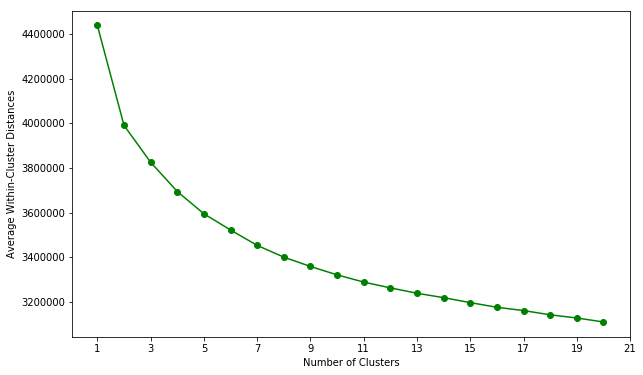

In [20]:
centers = np.linspace(1,20,20)
plt.figure(figsize=(10,6))
plt.plot(centers, scores, linestyle='-', marker='o', color='green')
plt.xticks(list(range(1,22,2)))
plt.ylabel('Average Within-Cluster Distances')
plt.xlabel('Number of Clusters')

To identify an ideal number of clusters the Elbow plot was created for the number of clusters from 1 to 21. 
The average within-cluster distances plotted against number of components demonstrates that
the score was rapidly decreased for the first 16 components and continue to decrease for higher number of clusters
but with lower slope. So, 16 clusters were selected.

In [21]:
n_components = 170
n_clusters = 16
cluster_p = Pipeline([
                        ('pca', PCA(n_components)),
                        ('kmeans', KMeans(n_clusters=n_clusters, random_state=42) )
                        ])

In [22]:
cluster_p.fit(cleaned_azdias)
prediction_azdias=cluster_p.predict(cleaned_azdias)
prediction_azdias[:20]

array([ 4,  0,  8,  9,  0, 12,  0,  9,  2,  0,  7,  7,  4,  0,  0,  4,  0,
        4,  4,  0], dtype=int32)

In [23]:
# calculate the percentage and count covered by the cluster of the general population

cluster_Azdias = pd.Series(prediction_azdias).value_counts().reset_index()
cluster_Azdias.columns   = ['Cluster', 'Count']
cluster_Azdias['dataset_name'] = 'Azdias'
cluster_Azdias['Percentage']  = cluster_Azdias['Count'] / cleaned_azdias.shape[0]

In [24]:
cluster_Azdias.head(5)

,Cluster,Count,dataset_name,Percentage
0,0,46012,Azdias,0.328916
1,4,28100,Azdias,0.200872
2,7,10529,Azdias,0.075266
3,9,9767,Azdias,0.069819
4,2,7686,Azdias,0.054943


In [25]:
customers.head(2)

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4


In [26]:
print("Cleaning Customers dataset \n")
cleaned_customers = clean_data(customers)

Cleaning Customers dataset 

Drop columns with more than 20% of missing values
Droping unnecessary columns that doesn't have description in Attribute Info file
droping column EINGEFUEGT_AM and D19_LETZTER_KAUF_BRANCHE because it contain too many different items
droping ID column from dataset
creating a copy of dataframe
Remove rows with less than 25 missing attributes
Re-encode OST_WEST_KZ attribute
Feature engineering WOHLANG
Droping WOHLANG column
Feature extracting CAMEO_DEUG_2015
remove columns with start with kba05
Imputing Nan values
Counting Nan values 0


In [27]:
print("Scaling the Customers dataset \n")
scaler = StandardScaler()
cleaned_customers[cleaned_customers.columns] = scaler.fit_transform(cleaned_customers) 

Scaling the Customers dataset 



In [28]:
print("Cluster Predictions of Customers dataset \n")
#cluster_pipeline.fit(cleaned_customers)
customers_predictions = cluster_p.predict(cleaned_customers)
customers_predictions[:20]

Cluster Predictions of Customers dataset 



array([ 7,  2,  2,  8,  0,  0,  0,  0,  0,  0,  0,  0, 13,  0,  0,  0,  0,
        0,  0,  0], dtype=int32)

In [29]:
# calculate the percentage and count covered by the cluster of the customers

cluster_Customer = pd.Series(customers_predictions).value_counts().reset_index()
cluster_Customer.columns   = ['Cluster', 'Count']
cluster_Customer['dataset_name'] = 'Customers'
cluster_Customer['Percentage']  = cluster_Customer['Count'] / cleaned_customers.shape[0]
cluster_Customer.head(5)

,Cluster,Count,dataset_name,Percentage
0,0,40965,Customers,0.724942
1,4,5631,Customers,0.099650
2,7,1958,Customers,0.034650
3,2,1936,Customers,0.034261
4,8,1122,Customers,0.019856


In [30]:
percent_Diff = pd.concat([ cluster_Azdias.groupby(['Cluster']).agg({'Percentage': ['sum']}), 
                      cluster_Customer.groupby(['Cluster']).agg({'Percentage': ['sum']}) ], axis = 1)
percent_Diff.columns = ['General Population', 'Customers']
percent_Diff['Difference'] = percent_Diff['Customers'] - percent_Diff['General Population']
percent_Diff.head(15)

,General Population,Customers,Difference
Cluster,,,
0,0.328916,0.724942,0.396026
1,0.017600,0.003415,-0.014184
2,0.054943,0.034261,-0.020683
3,0.031189,0.008990,-0.022199
4,0.200872,0.099650,-0.101223
5,0.018314,0.010282,-0.008033
6,0.000465,0.000726,0.000261
7,0.075266,0.034650,-0.040616
8,0.028265,0.019856,-0.008409


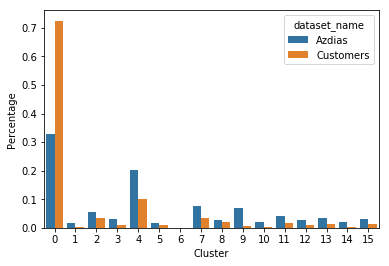

In [31]:
'''
comparision the percentage of customer data to the general population.
'''
dataset_Diff = pd.concat([cluster_Azdias, cluster_Customer], axis = 0,sort=True)     
sns.barplot(x = 'Cluster', y = 'Percentage', hue = 'dataset_name', data = dataset_Diff)
#plt.title(f'Distribution for a KMean model with {n_cluster} clusters (barplot).')
plt.show()

We noticed that people with following characteristics is more likely to be customers for mail oder

1. Financially Capable or good
2. Hold more shares
3. Higher online/transaction activities or crazy shopper
4. Older in age
5. Money savers